In [56]:
#Importing Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Path of data in drive
data_path='/content/drive/MyDrive/AlmaBetter/Capstone_Project/Capstone Project II/data_email_campaign.csv'
#Reading csv file
email_data=pd.read_csv(data_path)

In [4]:
email_data.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


#**Exploratory Data Analysis**

In [5]:
#Retreiving COlumn names
email_data.columns

Index(['Email_ID', 'Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Customer_Location', 'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links', 'Total_Images',
       'Email_Status'],
      dtype='object')

In [6]:
#getting the shape of dataset
email_data.shape

(68353, 12)

In [7]:
email_data.describe()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
count,68353.000000,68353.000000,68353.000000,68353.000000,61528.000000,68353.000000,68353.000000,66152.000000,66676.000000,68353.000000
mean,1.285094,1.095481,1.456513,2.272234,28.933250,1.999298,699.931751,10.429526,3.550678,0.230934
std,0.451462,0.997578,0.498109,0.468680,12.536518,0.631103,271.719440,6.383270,5.596983,0.497032
min,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,1.000000,0.000000,0.000000
25%,1.000000,0.200000,1.000000,2.000000,20.000000,2.000000,521.000000,6.000000,0.000000,0.000000
50%,1.000000,0.800000,1.000000,2.000000,28.000000,2.000000,694.000000,9.000000,0.000000,0.000000
75%,2.000000,1.800000,2.000000,3.000000,38.000000,2.000000,880.000000,14.000000,5.000000,0.000000
max,2.000000,5.000000,2.000000,3.000000,67.000000,3.000000,1316.000000,49.000000,45.000000,2.000000


In [8]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68353 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Email_ID                   68353 non-null  object 
 1   Email_Type                 68353 non-null  int64  
 2   Subject_Hotness_Score      68353 non-null  float64
 3   Email_Source_Type          68353 non-null  int64  
 4   Customer_Location          56758 non-null  object 
 5   Email_Campaign_Type        68353 non-null  int64  
 6   Total_Past_Communications  61528 non-null  float64
 7   Time_Email_sent_Category   68353 non-null  int64  
 8   Word_Count                 68353 non-null  int64  
 9   Total_Links                66152 non-null  float64
 10  Total_Images               66676 non-null  float64
 11  Email_Status               68353 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 6.3+ MB


##Analysing Categorical data

In [9]:
#creating new dataframe of only categorical columns
ds_cat = email_data.select_dtypes(include =['object','int']).copy()
#dropping Word_Count because it's numeric data
ds_cat.drop('Word_Count',axis=1,inplace=True)
ds_cat.head(2)

,Email_ID,Email_Type,Email_Source_Type,Customer_Location,Email_Campaign_Type,Time_Email_sent_Category,Email_Status
0,EMA00081000034500,1,2,E,2,1,0
1,EMA00081000045360,2,1,NaN,2,2,0


In [10]:
ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in ds_cat.columns:
    tmp['column'] = [c]
    tmp['values'] = [ds_cat[c].unique()]
    tmp['values_count_incna'] = len(list(ds_cat[c].unique()))
    tmp['values_count_nona'] = int(ds_cat[c].nunique())
    tmp['num_miss'] = ds_cat[c].isnull().sum()
    tmp['pct_miss'] = (ds_cat[c].isnull().sum()/ len(ds_cat)).round(3)*100
    ds_cat_stats = ds_cat_stats.append(tmp)
    
ds_cat_stats

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss
0,Email_ID,"[EMA00081000034500, EMA00081000045360, EMA0008...",68353,68353,0,0.0
0,Email_Type,"[1, 2]",2,2,0,0.0
0,Email_Source_Type,"[2, 1]",2,2,0,0.0
0,Customer_Location,"[E, nan, B, C, G, D, F, A]",8,7,11595,17.0
0,Email_Campaign_Type,"[2, 3, 1]",3,3,0,0.0
0,Time_Email_sent_Category,"[1, 2, 3]",3,3,0,0.0
0,Email_Status,"[0, 1, 2]",3,3,0,0.0


1.) As we can see we have 17% missing values in Customer Location.
<br>
2.) There is no missing values in any other categorical variable.
<br>
3.) Email_Type and Email_Source_Type have 2 categories.<br>
4.) Email_Campaign_Type,Time_Email_sent_Category and Email_Status have 3 Categories<br>
5.) Look at the Variable 'Customer_Location' -- distinct categories are 8 but without nans it is 7.

**Since we are working on a supervised ML problem we should also look at the relationshipt between the dependent variable and independent variable.**

In [11]:
#Dropping Email_ID column
ds_cat.drop('Email_ID',axis=1,inplace=True)

In [12]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 7 X categories, 3 hues =>
        ##    [0, 8, 16] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

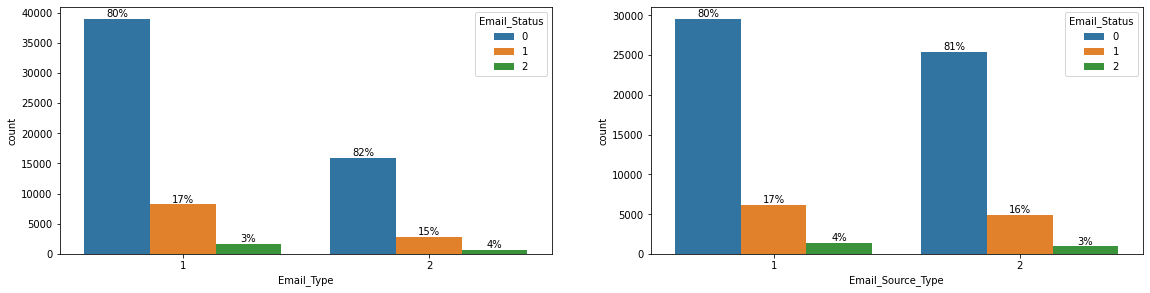

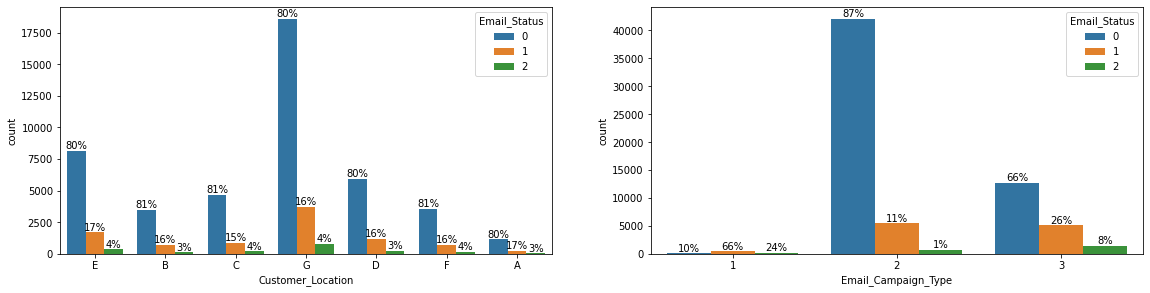

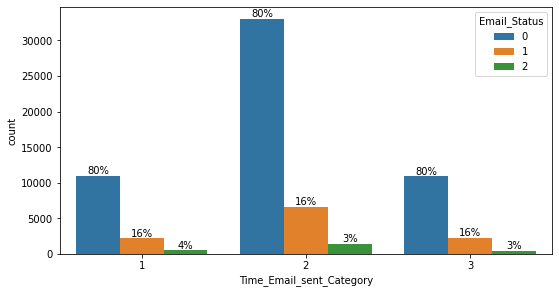

<Figure size 2160x720 with 0 Axes>

In [13]:

ix = 1
fig = plt.figure(figsize = (30,10))
for c in list(ds_cat.columns):
    if ix < 3:
        if c != 'Email_Status':
            ax1 = fig.add_subplot(2,3,ix)
            sns.countplot(data = ds_cat, x=c,hue='Email_Status' ,ax = ax1)
            barPerc(ds_cat,c,ax1)            
    ix = ix +1
    if ix == 3: 
        fig = plt.figure(figsize = (30,10))
        ix =1

As we can observe the distribution of Email_Status is almost similar in all the categories except in Email_Campaign_Type we can see that it shows a totally different trend . For Email_Campaign_Type=1 we see that only 10% of customers are ignoring the email and for 2 around 87% customer ignore the emails.

##Analysing Numerical Data

In [14]:
#creating new dataframe of only numerical columns
ds_num = email_data.select_dtypes(include =['float']).copy()
ds_num['Word_Count'] = email_data.loc[ds_num.index, 'Word_Count'].copy()
ds_num.head(2)

,Subject_Hotness_Score,Total_Past_Communications,Total_Links,Total_Images,Word_Count
0,2.2,33.0,8.0,0.0,440
1,2.1,15.0,5.0,0.0,504


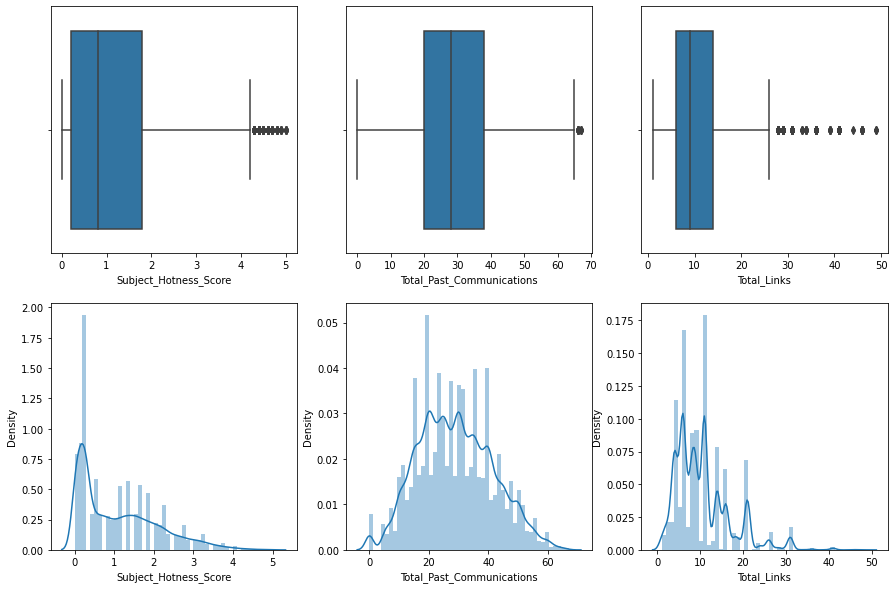

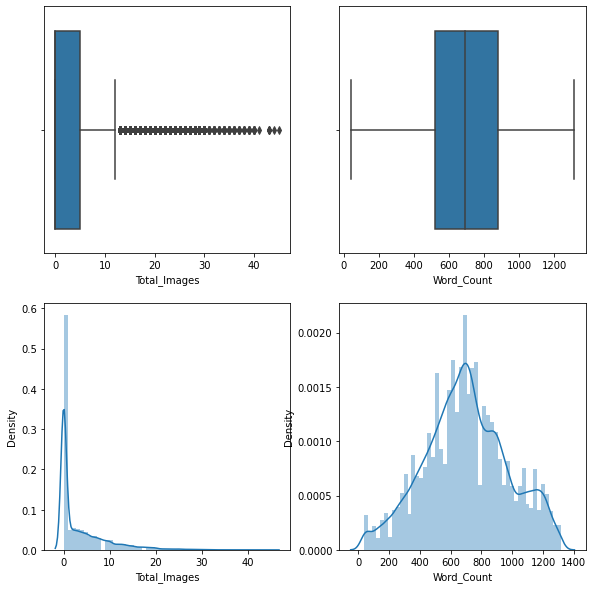

In [15]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(ds_num.columns):
    if ix <= 3:
            ax1 = fig.add_subplot(2,3,ix)
            sns.boxplot(data = ds_num, x=c, ax = ax1)
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.distplot(ds_num[c], ax=ax2)
            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

1.)There are **outliers** in **Subject_Hotness_Score,Total_Links and Total_Images** and also they are **Right Skewed**.
<br>
2.)There are few **outliers** in Total_Past_Communication.<br>

**Since we are working on a supervised ML problem we should also look at the relationshipt between the dependent variable and independent variable. In order to do that let's add our dependent variable to this dataset.**

In [16]:
ds_num['Email_Status'] = email_data.loc[ds_num.index, 'Email_Status'].copy()

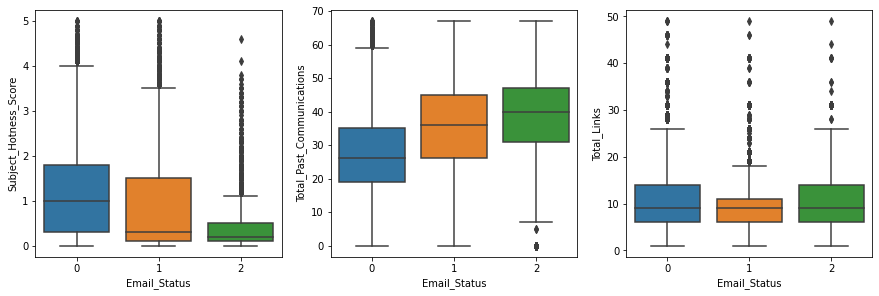

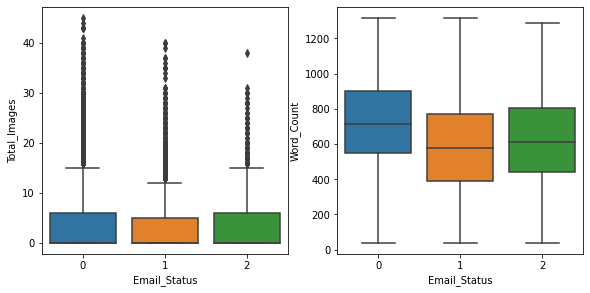

<Figure size 1080x720 with 0 Axes>

In [17]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(ds_num.columns):
    if ix <= 3:
        if c != 'Email_Status':
            ax1 = fig.add_subplot(2,3,ix)
            sns.boxplot(data=ds_num, x='Email_Status', y=c, ax=ax1)        
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1


1.) **Subject_Hotness_Score** -> All Email_Status i.e 0,1,2 have **outliers**. 0 have highest median and 1,2 are **right skewed**.
<br>
2.) **Total_Past_Communications** -> 0,2 have **outliers** and 2 have highest median .<br>
3.) **Total_Links** ->0,1,2 all have **outliers**,All have the same median but 0,2 have higher variance compare to 1.<br>
4.)**Total_Images** ->0,1,2 all have **outliers** and All have the same median.
<br>
5.)**Word_Count** ->Median of 0 is highest.

In [18]:
#sns.pairplot(email_data, hue='Email_Status')

We can observe that there is a relationship between total_images and total_links lets look into detail

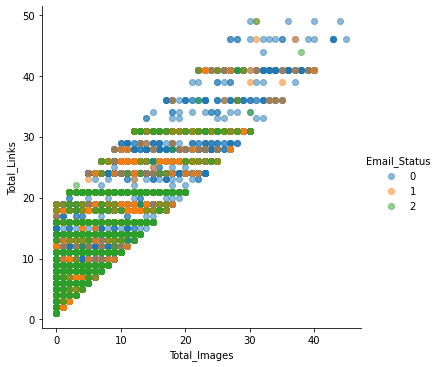

In [19]:
sns.lmplot(x='Total_Images', y='Total_Links', hue='Email_Status', data=email_data, fit_reg=False, scatter_kws={'alpha':0.5})

They are positively correlated

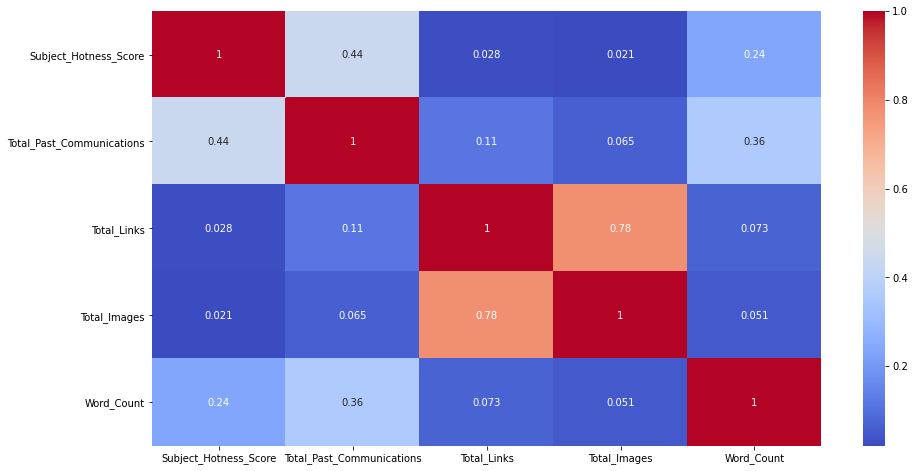

In [20]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = ds_num.drop('Email_Status',axis=1).corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Images and Links have 78% positive correlation lets look at each feature individually

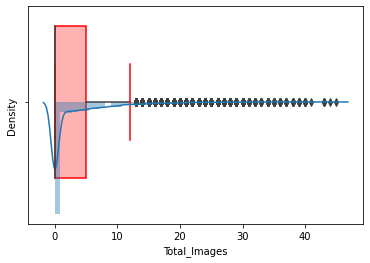

In [21]:
ax=sns.boxplot(ds_num['Total_Images'],capprops=dict(color="red"),boxprops=dict(facecolor="red", color="red"))
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.distplot(ds_num['Total_Images'])


There are outliers in total_images and also more than 50%  of value is filled with 0 

In [22]:
#Finding number of data having 0 images
img_cnt_0=ds_num[ds_num['Total_Images']==0].count()['Total_Images']
#Total number of non nan data
total=ds_num['Total_Images'].count()
#finding percentage
pcnt_img_0=(img_cnt_0/total)*100
print("Percentage of data having Total_Images Zero is = ",pcnt_img_0)

Percentage of data having Total_Images Zero is =  52.58263843061971


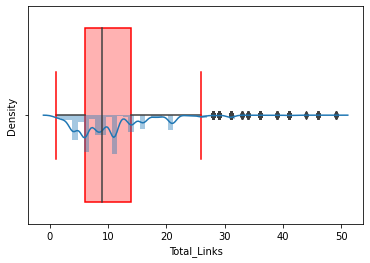

In [23]:
ax=sns.boxplot(ds_num['Total_Links'],capprops=dict(color="red"),boxprops=dict(facecolor="red", color="red"))
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.distplot(ds_num['Total_Links'])


There are few outliers lesser than Total_Images
<br>
Since images and links are correlated and most of the values in Total_Images is 0 we will keep Total_Links and drop Total_Images

In [24]:
#Dropping Total_Images  column
print('Shape of data before dropping ',email_data.shape)
email_data.drop('Total_Images',inplace=True,axis=1)
print('Shape of data after dropping ',email_data.shape)

Shape of data before dropping  (68353, 12)
Shape of data after dropping  (68353, 11)


In [25]:
# Number of NaNs for each object
email_data.isnull().sum()

Email_ID                         0
Email_Type                       0
Subject_Hotness_Score            0
Email_Source_Type                0
Customer_Location            11595
Email_Campaign_Type              0
Total_Past_Communications     6825
Time_Email_sent_Category         0
Word_Count                       0
Total_Links                   2201
Email_Status                     0
dtype: int64

###Treating Missing Values

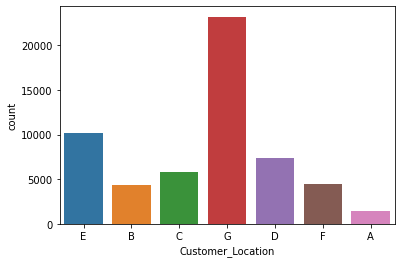

In [26]:
#Visualizing Customer_Location
sns.countplot(email_data['Customer_Location'])

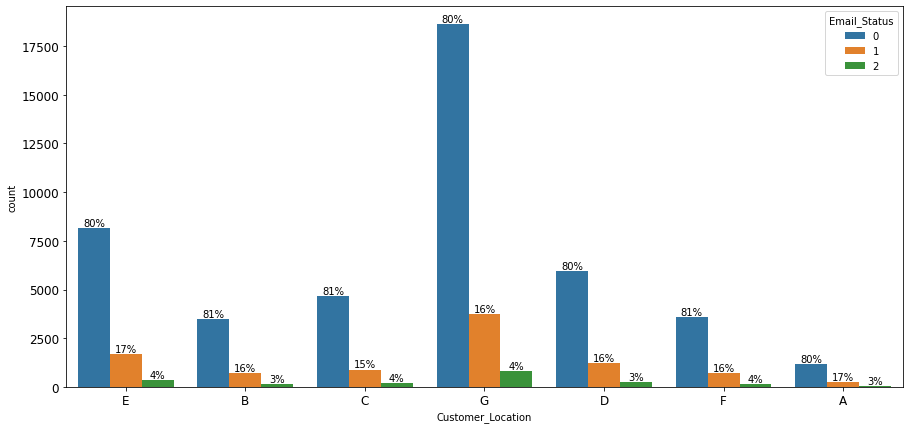

In [27]:
plt.figure(figsize=(15,7))
ax=sns.countplot(email_data['Customer_Location'],hue=email_data['Email_Status'])
plt.xticks(size=12)
plt.yticks(size=12)
barPerc(email_data,'Customer_Location',ax)

As we can see irrespective of location the ratio of Email_Status is same throughout .So we can drop the location column

In [28]:
print('Shape of data before dropping ',email_data.shape)
#dropping Customer_Location column
email_data.drop('Customer_Location',inplace=True,axis=1)
print('Shape of data after dropping ',email_data.shape)

Shape of data before dropping  (68353, 11)
Shape of data after dropping  (68353, 10)


Lets find out which metrics we should use to fill missing values of Total_Past_Communications column

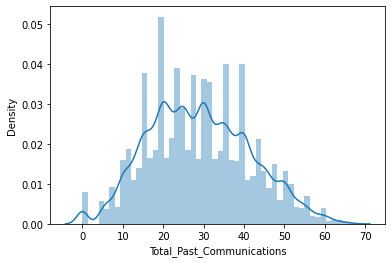

In [29]:
sns.distplot(email_data.Total_Past_Communications)

As we can observe the data is symmetricaly distributed so we can use mean value for imputing missing values

In [30]:
print('Number of missing values before imputing is = ',email_data['Total_Past_Communications'].isnull().sum())
email_data['Total_Past_Communications'].fillna(email_data['Total_Past_Communications'].mean(),inplace=True)
print('Number of missing values after imputing is = ',email_data['Total_Past_Communications'].isnull().sum())

Number of missing values before imputing is =  6825
Number of missing values after imputing is =  0


Now lets find out which metrics we should use to fill missing values of Total_Links column

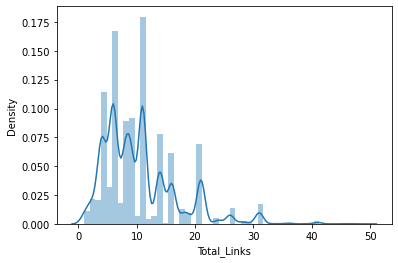

In [31]:
sns.distplot(email_data.Total_Links)

Since the data is not normally distributed we will use Mode to impute missing value

In [32]:
#Filling missing values of Total_Links column
print('Number of missing values before imputing is = ',email_data['Total_Links'].isnull().sum())
email_data['Total_Links'].fillna(email_data['Total_Links'].mode()[0],inplace=True)
print('Number of missing values after imputing is = ',email_data['Total_Links'].isnull().sum())

Number of missing values before imputing is =  2201
Number of missing values after imputing is =  0


In [33]:
email_data.isnull().sum()

Email_ID                     0
Email_Type                   0
Subject_Hotness_Score        0
Email_Source_Type            0
Email_Campaign_Type          0
Total_Past_Communications    0
Time_Email_sent_Category     0
Word_Count                   0
Total_Links                  0
Email_Status                 0
dtype: int64

Now we have no missing values

In [34]:
#Check for any duplicates data
email_data.duplicated().sum()

0

There is no duplicate data

###Outlier Treatment

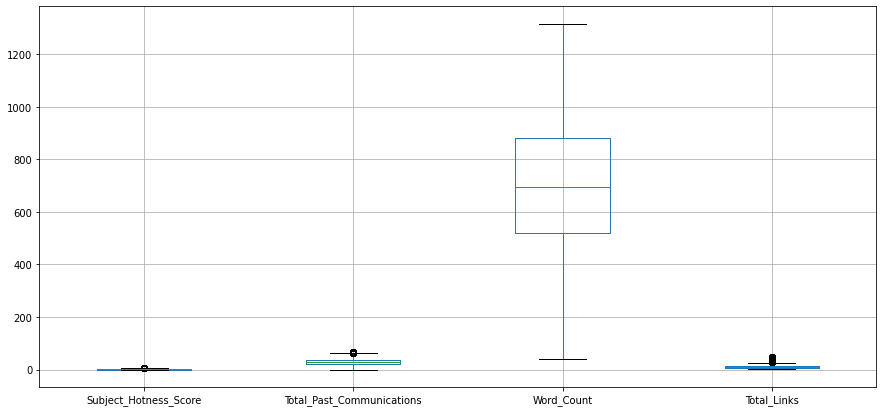

In [35]:
#Lets find out which all numerical column have outliers using boxplot
plt.figure(figsize=(15,7))
numerical_col=['Subject_Hotness_Score','Total_Past_Communications','Word_Count','Total_Links']
email_data.boxplot(numerical_col)


Except Word_Count column all other numeric column have outliers. Lets remove them.

In [36]:
#removing Word_Count because it does'nt have outlier
numerical_col.remove('Word_Count')
#iterating through each column which have outlier
for x in [y for y in numerical_col]:
    #Finding Quartile
    q75,q25 = np.percentile(email_data.loc[:,x],[75,25])
    #Calculating Inter Quartile Range
    intr_qr = q75-q25
    #Fixing Boundaries for outliers
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    #Imputing outliers with nan value
    email_data.loc[email_data[x] < min,x] = np.nan
    email_data.loc[email_data[x] > max,x] = np.nan

In [37]:
email_data.isnull().sum()

Email_ID                        0
Email_Type                      0
Subject_Hotness_Score         247
Email_Source_Type               0
Email_Campaign_Type             0
Total_Past_Communications     136
Time_Email_sent_Category        0
Word_Count                      0
Total_Links                  1608
Email_Status                    0
dtype: int64

We have 247 Outliers in Subject_Hotness_Score,136 in Subject_Hotness_Score and 1608 in Total_Links

In [38]:
#Dropping all the outliers
email_data.dropna(axis = 0,inplace=True)

In [39]:
email_data.isnull().sum()

Email_ID                     0
Email_Type                   0
Subject_Hotness_Score        0
Email_Source_Type            0
Email_Campaign_Type          0
Total_Past_Communications    0
Time_Email_sent_Category     0
Word_Count                   0
Total_Links                  0
Email_Status                 0
dtype: int64

In [40]:
#Dropping Email_ID column
print('Shape of data before dropping ',email_data.shape)
email_data.drop('Email_ID',inplace=True,axis=1)
print('Shape of data after dropping ',email_data.shape)

Shape of data before dropping  (66368, 10)
Shape of data after dropping  (66368, 9)


Now we are done with outlier treatment and missing value imputation lets move on to our dependent variable

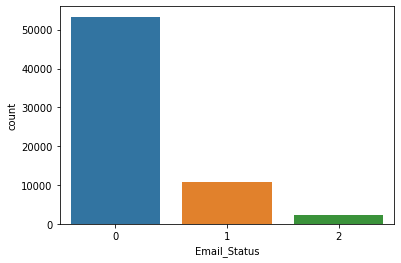

In [41]:
sns.countplot(email_data['Email_Status'])

In [43]:
email_data.groupby('Email_Status').count()['Email_Type']

Email_Status
0    53333
1    10726
2     2309
Name: Email_Type, dtype: int64

Dependent variable is highly imbalanced . Before treating that lets Normalize our data

###Feature Scaling

In [44]:
# apply normalization techniques
numerical_col=['Subject_Hotness_Score','Total_Past_Communications','Word_Count','Total_Links']
for column in numerical_col:
    email_data[column] = (email_data[column] - email_data[column].min()) / (email_data[column].max() - email_data[column].min()) 
# view normalized data
print(email_data)

       Email_Type  Subject_Hotness_Score  ...  Total_Links  Email_Status
0               1               0.523810  ...         0.28             0
1               2               0.500000  ...         0.16             0
2               2               0.023810  ...         0.16             1
3               1               0.714286  ...         0.60             0
4               1               0.000000  ...         0.12             0
...           ...                    ...  ...          ...           ...
68347           1               0.000000  ...         0.32             2
68348           2               0.095238  ...         0.60             0
68350           1               0.523810  ...         0.32             0
68351           1               0.095238  ...         0.52             0
68352           1               0.357143  ...         0.20             0

[66368 rows x 9 columns]


In [45]:
email_data.head()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Email_Status
0,1,0.523810,2,2,0.532258,1,0.313480,0.28,0
1,2,0.500000,1,2,0.241935,2,0.363636,0.16,0
2,2,0.023810,1,3,0.580645,2,0.722571,0.16,1
3,1,0.714286,2,2,0.403226,2,0.446708,0.60,0
4,1,0.000000,2,3,0.290323,2,0.710815,0.12,0


Lets Visualize our scaled data

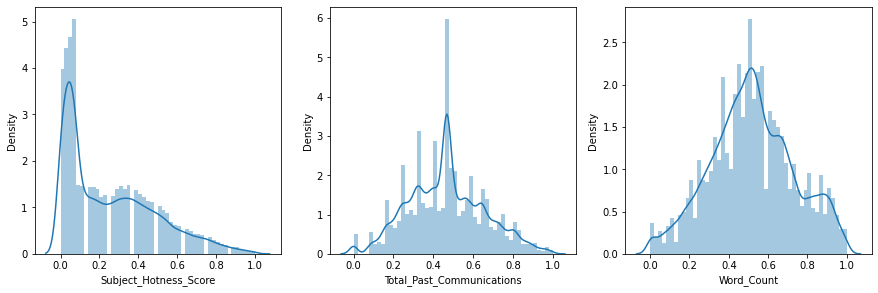

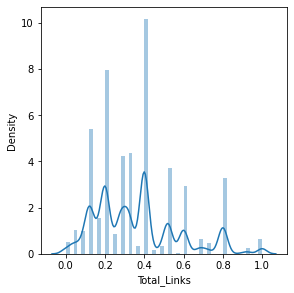

In [47]:
ix = 1
fig = plt.figure(figsize = (15,10))
for c in numerical_col:
    if ix <= 3:
            ax1 = fig.add_subplot(2,3,ix)
            sns.distplot(email_data[c], ax=ax1)
            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

Now we are done with scaling ,it's time to handle imbalance data

##**Imbalance Handling**

# 4. Synthetic Minority Oversampling Technique (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

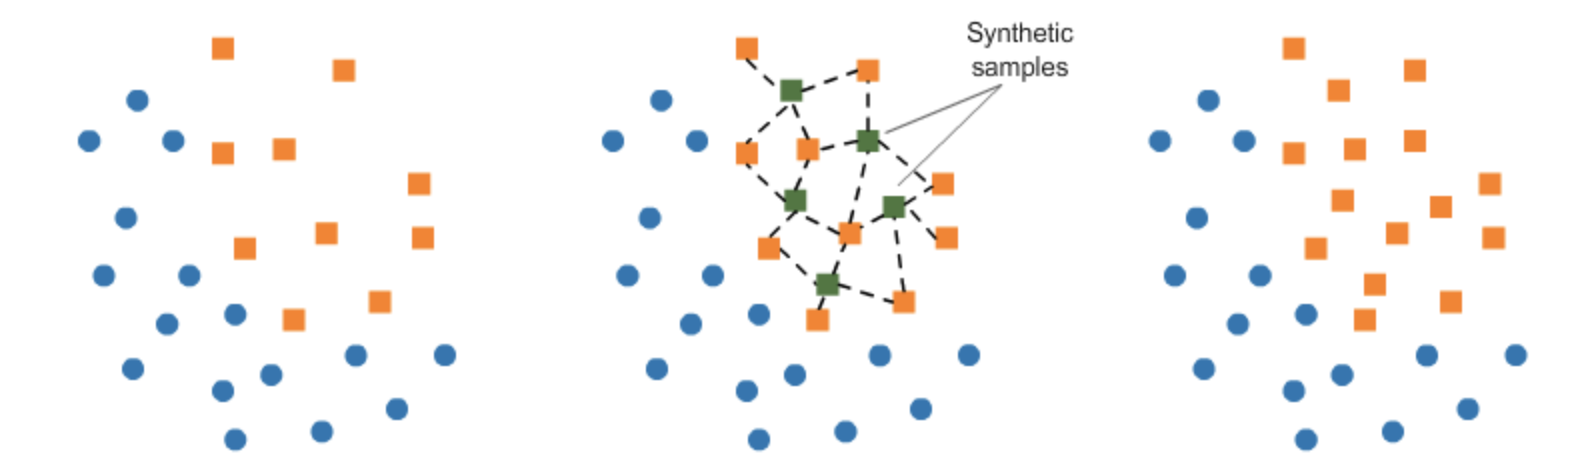

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(email_data.iloc[:,0:-1], email_data['Email_Status'])

print('Original dataset shape', len(email_data))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 66368
Resampled dataset shape 159999


In [54]:
unique_elements, counts_elements = np.unique(y_smote, return_counts=True)
print("Frequency of unique values of the Email_Status:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the Email_Status:
[[    0     1     2]
 [53333 53333 53333]]


Now we have a total balanced data 

In [57]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = 3)